In [14]:
import pandas as pd
import numpy as np
import scipy.stats # 통계 함수 사용
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 경고 무시
import warnings
warnings.filterwarnings(action = 'ignore')

In [15]:
# 코렙 한글깨짐
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 코렙에서 한글 깨짐 현상 있을때 설치 후 밑코드로 해결완료

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data = pd.read_excel('/content/drive/MyDrive/시소프로젝트/NEW(공모전용)/main_seoul_senior_data.xlsx', thousands=',')
data.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,연면적,도서관(500),...,병원(500),공원(500),버스(100),지하철(250),동별전체인구,60세~,60세~/전체인구,60세~/구별전체,비율,디지털정보지수
0,종로구,청운효자동,청운효자동 주민센터,서울특별시 종로구 자하문로 92,37.584083,126.970636,1.953680e+06,953451.030567,965.52,0.0,...,0.0,0.0,1.0,0.0,11978.0,2945.0,0.245867,0.075281,336867.539821,2933.53


In [18]:
data.shape

(509, 21)

# 데이터 탐색

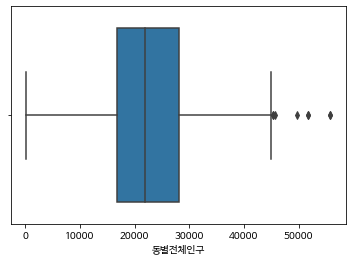

In [19]:
#데이터 탐색
sns.boxplot(x='동별전체인구' ,data = data)
plt.show()

In [20]:
data.columns = ['자치구', '동', '시설명', '주소', '연면적', '위도', '경도', '위도UTMK', '경도UTMK',
       '도서관(500)', '배움터(500)', '병원(500)', '공원(500)', '버스(100)', '지하철(250)',
       '동별전체인구', '동별시니어수', '행정동별시니어비율', '구별행정동시니어비율', '유동인구', '디지털정보지수']

In [21]:
#주변특성을 다 더한 데이터 df 생성 (버스 + 지하철도 합침)
df = data.copy() 
df.head(1)

,자치구,동,시설명,주소,연면적,위도,경도,위도UTMK,경도UTMK,도서관(500),...,병원(500),공원(500),버스(100),지하철(250),동별전체인구,동별시니어수,행정동별시니어비율,구별행정동시니어비율,유동인구,디지털정보지수
0,종로구,청운효자동,청운효자동 주민센터,서울특별시 종로구 자하문로 92,37.584083,126.970636,1.953680e+06,953451.030567,965.52,0.0,...,0.0,0.0,1.0,0.0,11978.0,2945.0,0.245867,0.075281,336867.539821,2933.53


In [22]:
data['유동인구'].sort_values(ascending = False)
#똑같은 이유 : 같은 동에 위치한 주민센터 및 복지관이라 

345    781018.306871
490    781018.306871
373    742686.898217
411    692729.819311
86     675296.756898
           ...      
3       94597.438184
23      77203.734008
17      46135.362979
351     30995.225550
412      2907.276232
Name: 유동인구, Length: 509, dtype: float64

In [23]:
# 이상치확인
q1 = df['유동인구'].quantile(0.25)
q3 = df['유동인구'].quantile(0.75)
iqr = q3-q1
rev_range = 3 #제거 범위 조절 변수 
df = df[(df['유동인구'] <= q3 + (rev_range*iqr) ) & (df['유동인구' ]>= q1 - (rev_range*iqr))]

In [24]:
df.shape, data.shape

((509, 21), (509, 21))

In [25]:
#df.drop(columns = ['위도', '경도','위도UTMK', '경도UTMK'], inplace = True)

In [26]:
df.columns

Index(['자치구', '동', '시설명', '주소', '연면적', '위도', '경도', '위도UTMK', '경도UTMK',
       '도서관(500)', '배움터(500)', '병원(500)', '공원(500)', '버스(100)', '지하철(250)',
       '동별전체인구', '동별시니어수', '행정동별시니어비율', '구별행정동시니어비율', '유동인구', '디지털정보지수'],
      dtype='object')

In [27]:
df.drop(columns = ['구별행정동시니어비율','연면적'], inplace = True)

In [28]:
df['주변특성'] = df['도서관(500)'] + df['배움터(500)'] + df['병원(500)'] + df['공원(500)']
df['대중교통'] = df['버스(100)'] + df['지하철(250)']

In [29]:
df.drop(columns = ['도서관(500)', '배움터(500)', '병원(500)',
       '공원(500)', '버스(100)', '지하철(250)'], inplace = True)

In [30]:
df.columns

Index(['자치구', '동', '시설명', '주소', '위도', '경도', '위도UTMK', '경도UTMK', '동별전체인구',
       '동별시니어수', '행정동별시니어비율', '유동인구', '디지털정보지수', '주변특성', '대중교통'],
      dtype='object')

In [31]:
df.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통
0,종로구,청운효자동,청운효자동 주민센터,서울특별시 종로구 자하문로 92,126.970636,1.953680e+06,953451.030567,965.52,11978.0,2945.0,0.245867,336867.539821,2933.53,0.0,1.0


In [32]:
# feature 변수만 X 변수로 저장 
#X2 = df.select_dtypes(exclude = [object])

In [33]:
# P-median 하기 위해 별도 생성 
X2 = df.iloc[:, 8:]

In [34]:
X2.columns

Index(['동별전체인구', '동별시니어수', '행정동별시니어비율', '유동인구', '디지털정보지수', '주변특성', '대중교통'], dtype='object')

In [35]:
pd.options.display.float_format = '{:.2f}'.format
# 소수점 2자리까지만 출력하겠다.

In [36]:
#Standardize data 
sc = StandardScaler()
X2_sc = sc.fit_transform(X2)
X2_sc

array([[-1.18161867, -1.18315737, -0.10230478, ..., -1.23245372,
        -0.95345728, -0.35057602],
       [-1.46551641, -1.3969157 ,  0.25232014, ..., -1.46560497,
         1.73275908, -0.35057602],
       [-1.702461  , -1.30101574,  2.47134563, ..., -1.51050935,
         2.62816453,  2.27358857],
       ...,
       [ 2.40196392,  1.48187563, -1.07072693, ...,  1.83560661,
        -0.05805183,  0.96150628],
       [-0.4402817 , -0.30616568,  0.20447717, ..., -0.34090115,
        -0.95345728,  0.96150628],
       [-1.21767782, -1.11235273,  0.31490026, ..., -1.13413517,
        -0.05805183, -0.35057602]])

#Sparse PCA 

In [37]:
from sklearn.decomposition import SparsePCA 

In [38]:
spca = SparsePCA(alpha = 0.01, random_state = 42)
pc = spca.fit_transform(X2_sc) # df 변수 확인 

explained_variance = np.var(pc, axis=0) # 설명변수 
explained_variance_ratio = explained_variance / np.sum(explained_variance) #누적 설명변수 

print("variance ratio(분산비율) : ", np.var(pc, axis=0))
print("culmulative variance ratio at SPC3 component : ", np.cumsum([e for e in explained_variance_ratio if e !=0]))


variance ratio(분산비율) :  [2.65112229 0.81332618 0.95764062 0.83642131 0.28462836 0.23307647
 0.06682052]
culmulative variance ratio at SPC3 component :  [0.45372344 0.59291927 0.75681363 0.89996205 0.94867446 0.98856408
 1.        ]


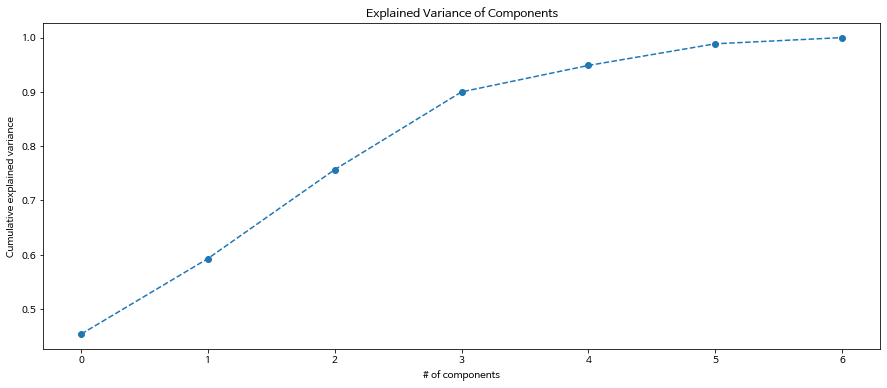

In [39]:
# cumulative variance plot 
plt.figure(figsize = (15,6))
plt.plot(range(0,np.cumsum([e for e in explained_variance_ratio if e !=0]).shape[0]), 
         np.cumsum([e for e in explained_variance_ratio if e !=0]), marker = 'o', linestyle = '--')

plt.title('Explained Variance of Components')
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')
plt.show()

## SPCA(n_component=3)

In [40]:
spca = SparsePCA(n_components = 3, alpha = 0.01)
pc = spca.fit_transform(X2_sc) # df 변수 확인 

explained_variance = np.var(pc, axis=0) # 설명변수 
explained_variance_ratio = explained_variance / np.sum(explained_variance) #누적 설명변수 

print("variance ratio(분산비율) : ", np.var(pc, axis=0))
print("culmulative variance ratio at SPC3 component : ", np.cumsum([e for e in explained_variance_ratio if e !=0]))


variance ratio(분산비율) :  [3.59046629 1.27364165 0.95530352]
culmulative variance ratio at SPC3 component :  [0.616981  0.8358419 1.       ]


In [41]:
spca_col = ['spca_component_'+ str(x+1) for x in range(3) ]
f_spca = pd.DataFrame(pc, columns = spca_col)

In [42]:
spca_components = pd.DataFrame(spca.components_, columns = list(X2.columns)) 
spca_components

,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통
0,0.49,0.51,0.00,0.48,0.51,0.05,0.00
1,-0.26,0.10,0.76,0.13,-0.05,0.54,0.20
2,0.07,-0.05,-0.26,-0.04,0.00,0.12,0.95


In [43]:
# SPCA축의 가장 중요한 변수
n_pcs= spca.components_.shape[0]
most_important = [np.abs(spca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X2.columns # Xcolumns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

df_pca = pd.DataFrame(dic.items())
df_pca.columns = ['spca','element']
df_pca['value']=None
for i in range(len(df_pca)):
    a = df_pca['element'][i]
    df_pca['value'][i] = spca_components[a][i]
    
df_pca

,spca,element,value
0,PC1,디지털정보지수,0.51
1,PC2,행정동별시니어비율,0.76
2,PC3,대중교통,0.95


# K-MEANS Clustering 

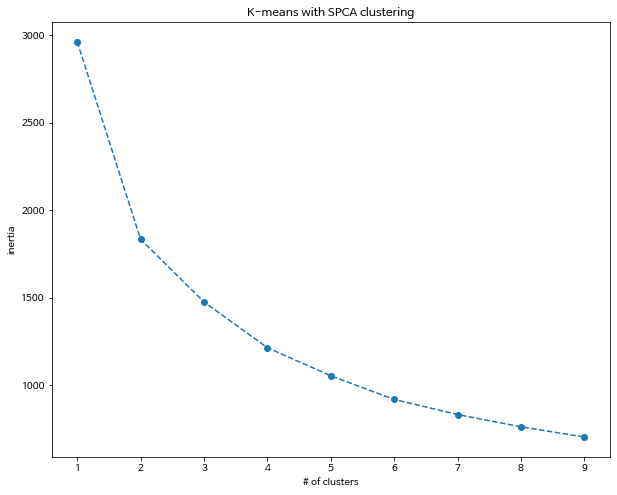

In [44]:
#K-means Clustering 
inertia = []
for i in range(1,10):
    kmeans_spca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_spca.fit(pc)
    inertia.append(kmeans_spca.inertia_)
    
# 최적의 Cluster 개수 찾기 (elbow point)
plt.figure(figsize = (10,8))
plt.plot(range(1,10), inertia, marker = 'o', linestyle = '--')
plt.xlabel('# of clusters')
plt.ylabel('inertia')
plt.title('K-means with SPCA clustering')
plt.show()

* inertia : k-평균 알고리즘은 클러스터 중심과 클러스터에 속한 샘플 사이의 거리를 잴 수 있는데,이 거리의 제곱 합을 이너셔(intertia)라고 부른다.이너셔는 클러스터에 속한 샘플이 얼마나 가깝게 모여 있는지를 나타내는 값이라고 생각할 수 있다.일반적으로 클러스터의 개수가 늘어나면 클러스터 개개의 크기는 줄어들기 때문에, 이너셔 또한 함께 줄어든다.

In [45]:
kmeans_spca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 100)
kmeans_spca.fit(pc)

df['kmeans'] = kmeans_spca.labels_

kmeans_spca_df = pd.concat([df, f_spca], axis = 1)
kmeans_spca_df.head(3)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
0,종로구,청운효자동,청운효자동 주민센터,서울특별시 종로구 자하문로 92,126.97,1953680.41,953451.03,965.52,11978.00,2945.00,0.25,336867.54,2933.53,0.00,1.00,2,-1.86,-0.42,-0.44
1,종로구,사직동,사직동 주민센터,서울특별시 종로구 사직로9길 1,126.97,1952805.72,953286.59,346.65,9372.00,2468.00,0.26,282305.29,2406.94,3.00,1.00,2,-2.28,1.27,-0.25
2,종로구,종로1.2.3.4가동,종로1-4가동 주민센터,서울특별시 종로구 종로17길 8,126.99,1952189.71,955056.68,1981.09,7197.00,2682.00,0.37,306783.95,2305.52,4.00,5.00,2,-2.20,3.97,1.66


In [46]:
# kmeans group 
group0 = kmeans_spca_df[kmeans_spca_df["kmeans"] == 0]
group1 = kmeans_spca_df[kmeans_spca_df["kmeans"] == 1]
group2 = kmeans_spca_df[kmeans_spca_df["kmeans"] == 2]
#group3 = kmeans_spca_df[kmeans_spca_df["kmeans"] == 3]

group0.shape, group1.shape, group2.shape#, group3.shape

((101, 19), (251, 19), (157, 19))

In [47]:
kmeans_spca_df['kmeans'].value_counts()

1    251
2    157
0    101
Name: kmeans, dtype: int64

In [48]:
cluster_mean = kmeans_spca_df.groupby('kmeans').mean()
cluster_mean

,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,spca_component_1,spca_component_2,spca_component_3
kmeans,,,,,,,,,,,,,,
0,126.98,1951129.23,954444.44,1860.37,35087.24,8905.78,0.26,513966.90,8998.05,1.39,1.60,2.84,0.25,0.00
1,127.00,1949650.23,955681.81,2004.38,23854.45,5687.67,0.24,341911.32,5898.89,0.92,1.66,0.12,-0.19,0.11
2,126.99,1949934.48,955580.62,1842.74,13289.14,3285.24,0.26,221364.72,3315.86,1.09,1.29,-2.02,0.14,-0.17


In [49]:
cluster_mean.loc[:,'동별전체인구'].min()

13289.140127388535

In [50]:
cp_colunms = ['동별전체인구', '동별시니어수', '행정동별시니어비율', '유동인구', '디지털정보지수', '주변특성', '대중교통']

for c in cp_colunms:
    sang = cluster_mean.loc[:,c].max()
    ha = cluster_mean.loc[:,c].min()
    jung = cluster_mean.loc[:,c].median()
    for j in range(3):
        if cluster_mean.loc[:,c][j] == ha:
            cluster_mean.loc[:,c][j] = '하'
        elif cluster_mean.loc[:,c][j] == sang:
            cluster_mean.loc[:,c][j] = '상'
        elif cluster_mean.loc[:,c][j] == jung:
            cluster_mean.loc[:,c][j] = '중'
cluster_mean

,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,spca_component_1,spca_component_2,spca_component_3
kmeans,,,,,,,,,,,,,,
0,126.98,1951129.23,954444.44,1860.37,상,상,상,상,상,상,중,2.84,0.25,0.00
1,127.00,1949650.23,955681.81,2004.38,중,중,하,중,중,하,상,0.12,-0.19,0.11
2,126.99,1949934.48,955580.62,1842.74,하,하,중,하,하,중,하,-2.02,0.14,-0.17


In [51]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def CompareGroups(target, n_clusters) : 
    
    '''
    ANOVA Test : 그룹 간의 평균의 차이가 유의미한지 검정
    Box Plot : 그룹 간의 차이 시각화 
    '''
    
    # ANOVA Test 
    anovamodel = ols(f'{target} ~ C(kmeans)', kmeans_spca_df[['kmeans', target, 'spca_component_1', 'spca_component_2', 'spca_component_3']]).fit()
    print(anova_lm(anovamodel), "\n")
    
    # Box Plot 
    #color_list = {n:c for n,c in color_list.items() if n < n_clusters}
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='kmeans', y=target, 
                data=kmeans_spca_df[['kmeans', target, 'spca_component_1', 'spca_component_2', 'spca_component_3']])

    plt.show()

* ols 함수: 
종속변수와 독립변수간의 회귀분석을 통해 .summary()로 확인할 수 있다.
ex) r2, F-statistic, coef, etc
* anova_lm 함수: 일원분산분석

              df  sum_sq  mean_sq    F  PR(>F)
C(kmeans)   2.00    0.03     0.01 5.40    0.00
Residual  506.00    1.21     0.00  NaN     NaN 



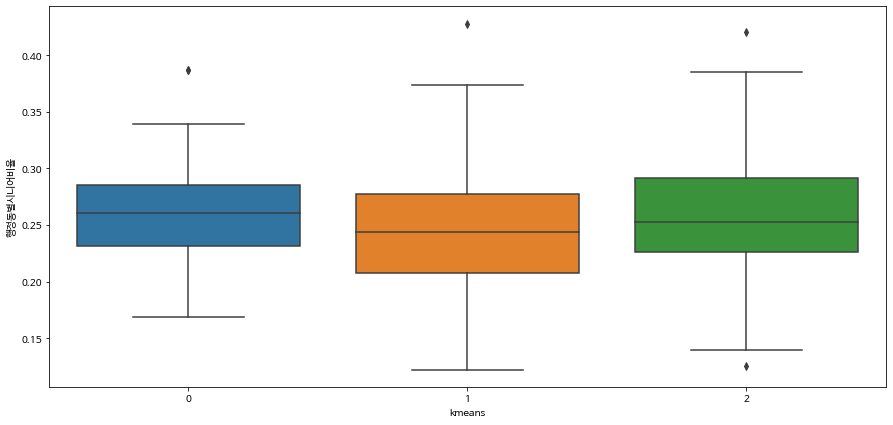

In [52]:
CompareGroups('행정동별시니어비율', 3) 

# 그래프

In [53]:
color_list = {0:"crimson", 1:"orange", 2:"green", 3:"royalblue", 4: "purple", 5: "dimgrey", 6: "gold"}

def ClusteringPlot( n_clusters, color_list) : 
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    color_list = {n:c for n,c in color_list.items() if n < n_clusters}
    ax.scatter(kmeans_spca_df['spca_component_1'], kmeans_spca_df['spca_component_2'], kmeans_spca_df['spca_component_3'],
               s=60, c = kmeans_spca_df['kmeans'].apply(lambda x: color_list[x]))
    
    # label the axes
    plt.title('spca & K-means Clustering', fontsize = 15)
    ax.set_xlabel("SPC1")
    ax.set_ylabel("SPC2")
    ax.set_zlabel("SPC3")
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_list.values()]
    plt.legend(markers, color_list.keys(), numpoints=1, bbox_to_anchor = (1.2,0.5))
    plt.show()

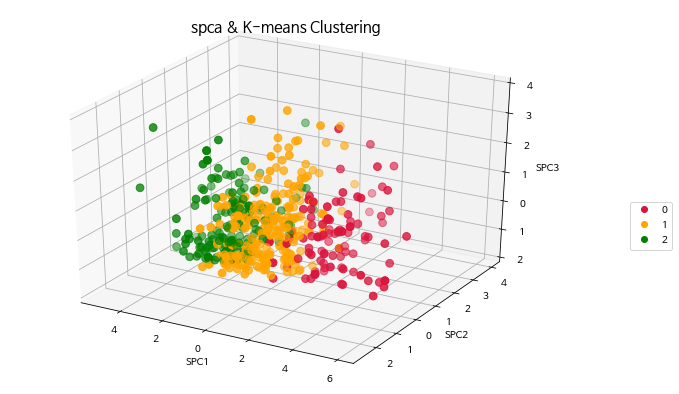

In [54]:
ClusteringPlot( 3, color_list)

## 0번 군집 추출

In [55]:
# df standard 한 것중 kmeans번만 index추출
dfclu2 = kmeans_spca_df[kmeans_spca_df['kmeans']==0]
dfclu2.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
68,광진구,중곡4동,중곡4동 주민센터,서울특별시 광진구 긴고랑로 131,127.09,1950853.71,963932.13,1707.99,28577.00,7834.00,0.27,423334.68,8239.49,0.00,4.00,0,1.67,0.12,1.26


In [56]:
dfclu2.shape

(101, 19)

In [57]:
dfclu2['자치구'].value_counts()

강서구     10
노원구      9
은평구      9
동대문구     8
강동구      7
동작구      6
구로구      6
중랑구      5
금천구      5
양천구      4
서대문구     4
도봉구      4
강북구      4
성북구      4
영등포구     3
서초구      3
강남구      3
마포구      2
관악구      2
송파구      2
광진구      1
Name: 자치구, dtype: int64

## 최종고려변수 : 1순위 대중교통, 2순위 연면적, 3순위 주변특성, 4순위 유동인구

## 연면적 평균 : 강서구 1944.502, 노원구 1450.54, 은평구 1764.31, 동대문구  1367.69, 강동구 1972.63

In [58]:
finalcenter = pd.read_excel('/content/drive/MyDrive/시소프로젝트/NEW(공모전용)/main_seoul_senior_data.xlsx', thousands=',')
finalcenter.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,연면적,도서관(500),...,병원(500),공원(500),버스(100),지하철(250),동별전체인구,60세~,60세~/전체인구,60세~/구별전체,비율,디지털정보지수
0,종로구,청운효자동,청운효자동 주민센터,서울특별시 종로구 자하문로 92,37.58,126.97,1953680.41,953451.03,965.52,0.00,...,0.00,0.00,1.00,0.00,11978.00,2945.00,0.25,0.08,336867.54,2933.53


## 강서구 시작

In [59]:
# 강서구 추출.
dfganeseo = dfclu2[dfclu2['자치구']=='강서구']
dfganeseo['시설명'].head(10)

240     염창동 주민센터
243    등촌3동 주민센터
244    우장산동 주민센터
245    화곡1동 주민센터
251    화곡본동 주민센터
255    발산1동 주민센터
257    방화1동 주민센터
474    강서노인종합복지관
475    화곡어르신복지센터
477    봉제산노인복지센터
Name: 시설명, dtype: object

In [60]:
# 인덱스 조정 작업.(240 -> 0)
dfganeseo = dfganeseo.reset_index()
gangseo = dfganeseo.iloc[:,1:]
gangseo.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
0,강서구,염창동,염창동 주민센터,서울특별시 강서구 양천로67가길 63,126.87,1950334.30,944651.04,1843.44,41637.00,7029.00,0.17,379099.07,8687.28,0.00,2.00,0,2.08,-2.18,0.77


In [61]:
# 강서구중 각 주민센터(입지선정)과 다른 주민센터와의 거리합.
distance = []
distance2 = []
for i in range(len(gangseo)):
    for j in range(len(gangseo)):
        distance.append(np.sqrt((gangseo['위도UTMK'][i] - gangseo['위도UTMK'][j])**2 + (gangseo['경도UTMK'][i] - gangseo['경도UTMK'][j])**2))
    distance2.append(sum(distance))
    distance= []
distance2

[26165.241695617104,
 13305.89429582004,
 24418.864023872633,
 13609.840963915876,
 13521.238500076879,
 15823.07788902908,
 28239.926183276333,
 15513.120459510857,
 18549.525108152393,
 15592.083872001782]

In [62]:
# 강서구의 인구 * 거리 값.
# ex) 1행은 염창동 주민센터에서 각 주민센터마다의 거리 * 염창동의 동별시니어수.
# p median 식이 수요 * 거리곱의 최소화. 
gangseopopdist = gangseo['동별시니어수']*distance2
print(gangseopopdist.sort_values())
a = gangseopopdist.argmin()
gangseo.iloc[a:a+1:]

4    99800261.37
5   114337560.83
9   115085171.06
1   130796940.93
7   152493974.12
3   168449001.61
0   183915483.88
2   211320849.26
8   229587472.26
6   280563666.63
Name: 동별시니어수, dtype: float64


,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
4,강서구,화곡본동,화곡본동 주민센터,서울특별시 강서구 초록마을로5길 29,126.85,1949313.09,942559.17,1422.55,34202.00,7381.00,0.22,398083.68,7706.07,1.00,0.00,0,1.67,-0.94,-0.71


### 화곡본동 주민센터는 대중교통 0 이라 패스

In [63]:
gangseo.iloc[2:3,:]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
2,강서구,우장산동,우장산동 주민센터,서울특별시 강서구 우현로 34,126.84,1949788.78,942044.36,4104.56,42923.00,8654.00,0.20,466741.12,9995.12,1.00,2.00,0,3.21,-1.09,0.63


### 강서구 10개행 연면적 평균은 1944.502 , 우장산동 주민센터는 그보다 높은 4104.56 확인

In [64]:
# 강서 유동인구 평균
gangseo['유동인구'].mean()

496296.7145746051

### 유동인구가 466741.12 - 평균은 496296.71 이지만, 절대적인 수치에서 밀리는 것이 아니기 때문에 채택.

### 우장산동 주민센터는 대중교통, 연면적, 주변특성(평균 1.1), 유동인구가 적절하여 채택.

## 강서구는 우장산동 주민센터

## 노원구 시작

In [65]:
# 노원구 추출.
dfnowon = dfclu2[dfclu2['자치구']=='노원구']
dfnowon['시설명'].head(10)

158      월계2동 주민센터
159      월계3동 주민센터
160      공릉1동 주민센터
161      공릉2동 주민센터
165      상계1동 주민센터
167     상계3.4동주민센터
169     상계6.7동주민센터
173    중계2.3동 주민센터
454      공릉어르신복지센터
Name: 시설명, dtype: object

In [66]:
# 인덱스 조정 작업.(158 -> 0)
dfnowon = dfnowon.reset_index()
nowon = dfnowon.iloc[:,1:]
nowon.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
0,노원구,월계2동,월계2동 주민센터,서울특별시 노원구 초안산로5길 28,127.05,1958993.28,960436.12,2242.89,26568.00,8264.00,0.31,469066.11,7618.33,0.00,0.00,0,1.69,0.39,-1.45


In [67]:
# 노원구중 각 주민센터(입지선정)과 다른 주민센터와의 거리합.
distance = []
distance2 = []
for i in range(len(nowon)):
    for j in range(len(nowon)):
        distance.append(np.sqrt((nowon['위도UTMK'][i] - nowon['위도UTMK'][j])**2 + (nowon['경도UTMK'][i] - nowon['경도UTMK'][j])**2))
    distance2.append(sum(distance))
    distance= []
distance2

[17675.350253329434,
 12659.709054866102,
 11295.44518731485,
 18403.88421119438,
 13520.437358038314,
 16355.376065575298,
 11216.947043183703,
 14911.472420831084,
 11499.246386789653]

In [68]:
# 노원구의 인구 * 거리 값.
# p median 식이 수요 * 거리곱의 최소화. 
nowonpopdist = nowon['동별시니어수']*distance2
print(nowonpopdist.sort_values())
a = nowonpopdist.argmin()
nowon.iloc[a:a+1:]

6    83364350.42
8    95213760.08
2   109136591.40
1   109810316.34
5   139691266.98
4   144033219.18
0   146069094.49
7   151008481.21
3   152384161.27
Name: 동별시니어수, dtype: float64


,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
6,노원구,상계6.7동,상계6.7동주민센터,서울특별시 노원구 노원로 429,127.07,1961488.88,961996.78,653.28,32641.00,7432.00,0.23,421841.64,8382.82,1.00,3.00,0,1.86,-0.37,1.05


### 노원구 9개 행 연면적 평균은 1450 이고, 공릉어르신복지센터는 584라서 부적절

In [69]:
nowon.iloc[6:7]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
6,노원구,상계6.7동,상계6.7동주민센터,서울특별시 노원구 노원로 429,127.07,1961488.88,961996.78,653.28,32641.00,7432.00,0.23,421841.64,8382.82,1.00,3.00,0,1.86,-0.37,1.05


### 노원구 9개 행 연면적 평균은 1450 이고, 상계6.7 주민센터는 653 이라서 부적절

In [70]:
nowon.iloc[1:2]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
1,노원구,월계3동,월계3동 주민센터,서울특별시 노원구 마들로 57,127.06,1959213.35,961372.55,660.50,29885.00,8674.00,0.29,492337.78,7956.12,0.00,2.00,0,2.13,0.23,-0.09


### 월계 3동 주민센터는 대중교통은 2 이지만, 연면적이 650 - 평균이 1450 이라 기각

In [71]:
nowon.iloc[7:8]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
7,노원구,중계2.3동,중계2.3동 주민센터,서울특별시 노원구 노원로17길 56,127.07,1960076.42,962139.41,2695.00,34196.00,10127.00,0.30,574810.32,9232.26,3.00,2.00,0,3.45,1.76,0.14


In [72]:
# 노원구 유동인구 평균
nowon['유동인구'].mean()

503986.2318664088

### 대중교통, 연면적(2695) - 평균은 1450, 주변특성, 유동인구 준수하여 채택.

## 노원구는 중계 2,3동 주민센터

## 은평구 시작

In [73]:
# 은평구 추출.
dfeunpyeong = dfclu2[dfclu2['자치구']=='은평구']
dfeunpyeong['시설명'].head(10)

177     녹번동 주민센터
178    불광1동 주민센터
179    불광2동 주민센터
182     구산동 주민센터
187     역촌동 주민센터
191     진관동 주민센터
455    은평노인종합복지관
456     역촌노인복지센터
459      불광노인복지관
Name: 시설명, dtype: object

In [74]:
# 인덱스 조정 작업.(177 -> 0)
dfeunpyeong = dfeunpyeong.reset_index()
eunpyeong = dfeunpyeong.iloc[:,1:]
eunpyeong.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
0,은평구,녹번동,녹번동 주민센터,서울특별시 은평구 은평로 195,126.92,1955373.67,948630.70,2420.45,36807.00,9958.00,0.27,492122.87,9604.62,1.00,3.00,0,3.21,0.35,0.76


In [75]:
# 은평구중 각 주민센터(입지선정)과 다른 주민센터와의 거리합.
distance = []
distance2 = []
for i in range(len(eunpyeong)):
    for j in range(len(eunpyeong)):
        distance.append(np.sqrt((eunpyeong['위도UTMK'][i] - eunpyeong['위도UTMK'][j])**2 + (eunpyeong['경도UTMK'][i] - eunpyeong['경도UTMK'][j])**2))
    distance2.append(sum(distance))
    distance= []
distance2

[10823.868140215112,
 12950.4788920931,
 10204.717758001192,
 12666.640075407,
 9271.765227191696,
 13106.72321744851,
 16187.154566256098,
 10684.99548945671,
 10592.131058937004]

In [76]:
# 은평구의 인구 * 거리 값.
# p median 식이 수요 * 거리곱의 최소화. 
eunpyeongpopdist = eunpyeong['동별시니어수']*distance2
print(eunpyeongpopdist.sort_values())
a = eunpyeongpopdist.argmin()
eunpyeong.iloc[a:a+1:]

2    87015628.32
8    90319101.54
0   107784078.94
4   112021467.47
3   112885096.35
7   129096115.50
1   142804930.74
5   157346212.23
6   194326790.57
Name: 동별시니어수, dtype: float64


,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
2,은평구,불광2동,불광2동 주민센터,서울특별시 은평구 연서로41길 16,126.93,1958396.03,949647.22,1266.42,27545.00,8527.00,0.31,421403.06,7905.73,1.00,0.00,0,1.73,0.76,-1.33


### 불광노인복지관, 대중교통 0 이라 기각.

In [77]:
eunpyeong.iloc[2:3]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
2,은평구,불광2동,불광2동 주민센터,서울특별시 은평구 연서로41길 16,126.93,1958396.03,949647.22,1266.42,27545.00,8527.00,0.31,421403.06,7905.73,1.00,0.00,0,1.73,0.76,-1.33


### 불광2동 주민센터 대중교통 0 이라 기각.

In [78]:
eunpyeong.iloc[3:4]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
3,은평구,구산동,구산동 주민센터,서울특별시 은평구 갈현로17길 10,126.91,1956718.85,948118.84,998.41,32207.00,8912.00,0.28,440429.70,8919.75,1.00,0.00,0,2.36,0.15,-1.12


### 구산동 주민센터 대중교통 0 이라 기각.

In [79]:
eunpyeong.iloc[4:5]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
4,은평구,역촌동,역촌동 주민센터,서울특별시 은평구 연서로 59,126.92,1956517.60,948662.18,1812.75,45384.00,12082.00,0.27,597090.63,12093.22,1.00,2.00,0,5.11,0.11,0.16


In [80]:
# 은평구 유동인구 평균
eunpyeong['유동인구'].mean()

522340.3583662012

### 은평구 9개행 대중교통, 연면적(1812) - 평균은 1450.54, 주변특성, 유동인구 준수라 채택.

## 은평구는 역촌동 주민센터

## 동대문구 시작

In [81]:
# 동대문구 추출.
dfeastbigdoor = dfclu2[dfclu2['자치구']=='동대문구']
dfeastbigdoor['시설명'].head(10)

80       용신동 주민센터
81       제기동 주민센터
82      전농1동 주민센터
85     답십리2동 주민센터
86      장안1동 주민센터
87      장안2동 주민센터
88      청량리동 주민센터
435    동대문노인종합복지관
Name: 시설명, dtype: object

In [82]:
# 인덱스 조정 작업.(80 -> 0)
dfeastbigdoor = dfeastbigdoor.reset_index()
eastbigdoor = dfeastbigdoor.iloc[:,1:]
eastbigdoor.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
0,동대문구,용신동,용신동 주민센터,서울특별시 동대문구 천호대로27길 35,127.04,1952731.88,959331.47,1591.58,31619.00,8144.00,0.26,569731.36,7787.33,2.00,3.00,0,2.47,0.80,0.90


In [83]:
# 동대문구중 각 주민센터(입지선정)과 다른 주민센터와의 거리합.
distance = []
distance2 = []
for i in range(len(eastbigdoor)):
    for j in range(len(eastbigdoor)):
        distance.append(np.sqrt((eastbigdoor['위도UTMK'][i] - eastbigdoor['위도UTMK'][j])**2 + (eastbigdoor['경도UTMK'][i] - eastbigdoor['경도UTMK'][j])**2))
    distance2.append(sum(distance))
    distance= []
distance2

[11931.23930794988,
 12543.660580793263,
 9294.331432078594,
 10139.557726937159,
 12039.901773388428,
 14356.799050464342,
 9069.260709216296,
 11444.641574922536]

In [84]:
# 동대문구의 인구 * 거리 값.
# p median 식이 수요 * 거리곱의 최소화. 
eastbigdoorpopdist = eastbigdoor['동별시니어수']*distance2
print(eastbigdoorpopdist.sort_values())
a = eastbigdoorpopdist.argmin()
eastbigdoor.iloc[a:a+1:]

6    66051425.75
2    74689247.39
3    80923810.22
7    83351324.59
0    97168012.92
1    98944394.66
5   109571090.35
4   116221171.82
Name: 동별시니어수, dtype: float64


,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
6,동대문구,청량리동,청량리동 주민센터,서울특별시 동대문구 왕산로43다길 5,127.05,1953886.36,960218.93,988.37,18813.00,7283.00,0.39,509498.22,5953.89,4.00,2.00,0,1.07,3.92,-0.33


In [85]:
# 동대문구 유동인구
eastbigdoor['유동인구'].mean()

558783.0565443034

### 동대문구는 전농1동 - 전농1동 주민센터

### 전농 1동 주민센터는 대중교통 0 이라 기각.

In [86]:
eastbigdoor.iloc[6:7]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
6,동대문구,청량리동,청량리동 주민센터,서울특별시 동대문구 왕산로43다길 5,127.05,1953886.36,960218.93,988.37,18813.00,7283.00,0.39,509498.22,5953.89,4.00,2.00,0,1.07,3.92,-0.33


### 청량리동 주민센터 연면적이 988.37 - 평균이 1367.693 이라 기각.

In [87]:
eastbigdoor.iloc[7:8]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
7,동대문구,청량리동,동대문노인종합복지관,서울특별시 동대문구 제기로33길 25,127.05,1953974.88,960361.76,2396.00,18813.00,7283.00,0.39,509498.22,5953.89,4.00,1.00,0,1.06,3.81,-0.95


### 동대문구 노인종합복지관 는 대중교통 有, 연면적(2396) - 평균은 1367.23 이고, 주변특성, 유동인구 준수하여 채택.

## 동대문구는 동대문구노인종합복지관

## 강동구 시작

In [88]:
# 강동구 추출.
dfrivereast = dfclu2[dfclu2['자치구']=='강동구']
dfrivereast['시설명'].head(10)

410     상일동 주민센터
411      길동 주민센터
414    암사1동 주민센터
420    천호1동 주민센터
421    천호2동 주민센터
423     강일동 주민센터
504      해공노인복지관
Name: 시설명, dtype: object

In [89]:
# 인덱스 조정 작업.(410 -> 0)
dfrivereast = dfrivereast.reset_index()
rivereast = dfrivereast.iloc[:,1:]
rivereast.head(1)

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
0,강동구,상일1동,상일동 주민센터,서울 강동구 구천면로 633,127.17,1949897.14,970898.01,2097.06,38834.00,7184.00,0.18,409526.91,10692.29,0.00,2.00,0,2.54,-1.85,0.64


In [90]:
# 강동구중 각 주민센터(입지선정)과 다른 주민센터와의 거리합.
distance = []
distance2 = []
for i in range(len(rivereast)):
    for j in range(len(rivereast)):
        distance.append(np.sqrt((rivereast['위도UTMK'][i] - rivereast['위도UTMK'][j])**2 + (rivereast['경도UTMK'][i] - rivereast['경도UTMK'][j])**2))
    distance2.append(sum(distance))
    distance= []
distance2

[19205.59418724403,
 14534.21696216015,
 13963.31271111828,
 13149.934878913467,
 17047.386643596732,
 28133.018626464327,
 14646.324220842784]

In [91]:
# 강동구의 인구 * 거리 값.
# p median 식이 수요 * 거리곱의 최소화. 
rivereastpopdist = rivereast['동별시니어수']*distance2
print(rivereastpopdist.sort_values())
a = rivereastpopdist.argmin()
rivereast.iloc[a:a+1:]

3   102096094.40
2   125963043.97
6   127335142.78
0   137972988.64
4   148209979.48
1   176619804.52
5   221238058.48
Name: 동별시니어수, dtype: float64


,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
3,강동구,천호1동,천호1동 주민센터,서울특별시 강동구 구천면로42길 59,127.14,1949387.65,968010.59,2139.32,26738.00,7764.00,0.29,442590.05,7519.02,2.00,0.00,0,1.56,0.96,-1.13


### 천호1동 주민센터는 대중교통 0 이라 기각.

In [92]:
rivereast.iloc[6:7]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
6,강동구,천호2동,해공노인복지관,서울특별시 강동구 천중로17길 42-16,127.13,1949452.26,967593.32,598.00,33154.00,8694.00,0.26,495605.09,8661.42,3.00,0.00,0,2.62,0.90,-0.86


### 해공 노인복지관도 대중교통 0 이라 기각

In [93]:
rivereast.iloc[2:3]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
2,강동구,암사1동,암사1동 주민센터,서울특별시 강동구 올림픽로98가길 57,127.13,1949919.44,967655.77,771.00,34486.00,9021.00,0.26,514245.86,9359.65,3.00,0.00,0,2.99,0.88,-0.85


### 암사1동 주민센터 대중교통 0 이라 기각

In [94]:
rivereast.iloc[4:5]

,자치구,동,시설명,주소,위도,경도,위도UTMK,경도UTMK,동별전체인구,동별시니어수,행정동별시니어비율,유동인구,디지털정보지수,주변특성,대중교통,kmeans,spca_component_1,spca_component_2,spca_component_3
4,강동구,천호2동,천호2동 주민센터,서울특별시 강동구 올림픽로 698,127.12,1948866.39,967003.02,2707.86,33154.00,8694.00,0.26,495605.09,8661.42,3.00,1.00,0,2.62,1.01,-0.24


In [95]:
# 강동구 유동인구
rivereast['유동인구'].mean()

500992.8928876426

## 강동구는 천호2동 주민센터